# EuroSat Image Classification using MobileNet

Hector Becerra  
Juan Terven  
2023

**MobileNets** are a class of efficient convolutional neural network (CNN) architectures designed specifically for mobile and edge devices, where computational resources and power are limited. Introduced by Google researchers Andrew Howard, Menglong Zhu, and others, MobileNets are characterized by their use of depthwise separable convolutions, a technique that significantly reduces the model's size and computational complexity while maintaining competitive performance. These architectures are highly customizable through hyperparameters that trade off between latency and accuracy, making them ideal for real-time applications such as object detection, facial recognition, and augmented reality on smartphones and IoT devices. MobileNets have become a go-to choice for on-device machine learning, balancing efficiency and effectiveness in resource-constrained environments.

In [1]:
import os
import numpy as np 
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wandb
from torch.utils.data import DataLoader
import json
from torchvision.models import mobilenet_v3_small,MobileNet_V3_Small_Weights

from train_utils import get_predictions,compute_val_loss,EarlyStopping,train_model
from eval_utils import remove_wandb_hooks,evaluate_test_set,precision_recall_analysis
from EuroSAT import EurosatDataset,visualize_classes


In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")  
    print("Found GPU")
else:
    torch.device("cpu")
    
print("Pytorch version:", torch.__version__)

Found GPU
Pytorch version: 1.12.1+cu116


## Login to Wandb to log experiment

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'EuroSat_MobileNet_Classifier.ipynb'

wandb.login()

wandb: Currently logged in as: jrterven. Use `wandb login --relogin` to force relogin


True

# Data
The [EuroSat Dataset](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8736785) consists of 27,000 labeled images with ten different land use and land cover classes. It is multi-spectral, covering 13 spectral bands in the visible, near infrared, and short wave infrared parts of the spectrum. The dataset is geo-referenced and based on openly and freely accessible earth observation data. The classes are the following.

| No. | Land Use Type           |
|-----|-------------------------|
| 1   | AnnualCrop              |
| 2   | Forest                  |
| 3   | HerbaceousVegatation    |
| 4   | Highway                 |
| 5   | Industrial              |
| 6   | Pasture                 |
| 7   | PermanentCrop           |
| 8   | Residential             |
| 9   | River                   |
| 10  | SeaLake                 |

In [3]:
data_path = "/datasets/eurosat/EuroSAT/"

In [4]:
# Load the labels 
f = open(f"{data_path}label_map.json", "r")
label_to_index = json.load(f)

In [5]:
index_to_label = {label_to_index[k]:k for k in label_to_index}
print(index_to_label)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


## Data Transformations

In [6]:
# Define a sequence of transformations to be applied to images
transformToTensor = transforms.Compose([
    # Resize the image to have a minimum size of 64 pixels along the shortest dimension,
    # preserving the aspect ratio of the original image.
    transforms.Resize((64,)),

    # Crop the image at the center to get a 64x64 square.
    transforms.CenterCrop((64, 64)),

    # Convert the image to a PyTorch tensor.
    transforms.ToTensor(),

    # Normalize the tensor image with mean and standard deviation for each color channel.
    # These specific values are generally used for pre-trained models.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Create dataset instances
# Instantiate the EurosatDataset class for training data.
train_dataset = EurosatDataset(_type='train', transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for validation data.
valid_dataset = EurosatDataset(_type="valid", transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for testing data.
test_dataset = EurosatDataset(_type="test", transform=transformToTensor,
                              data_path=data_path)

# Define batch sizes for training and validation data.
train_batch = 64  # The batch size for training data.
val_batch = 16     # The batch size for validation data.

# Create DataLoaders
# Create a DataLoader for the training dataset. This DataLoader will automatically
# group the training data into batches of size 128 and shuffle them in each epoch.
train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)

# Create a DataLoader for the validation dataset. This DataLoader groups the validation
# data into batches of size 32. The data is not shuffled, which is typical for validation data.
valid_loader = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False)

# Create a DataLoader for the testing dataset. This DataLoader processes the test data
# one sample at a time (batch size of 1) and does not shuffle the data. This is typical
# for test data since we often want to evaluate the model on test data in a specific order.
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

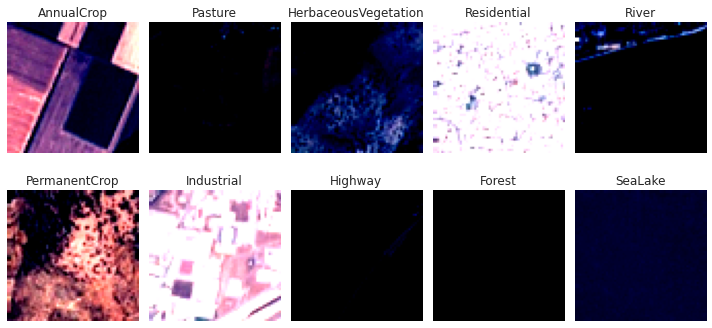

In [8]:
visualize_classes(train_loader, index_to_label)

In [9]:
dataset_managers = {
    'valid': valid_loader,
    'train': train_loader,
    'test': test_loader
}

print(f"Train set batches: {len(train_loader)}")
print(f"Validation set batches: {len(valid_loader)}")
print(f"Test set examples: {len(test_loader)}")

Train set batches: 296
Validation set batches: 338
Test set examples: 2700


## Labels distribution

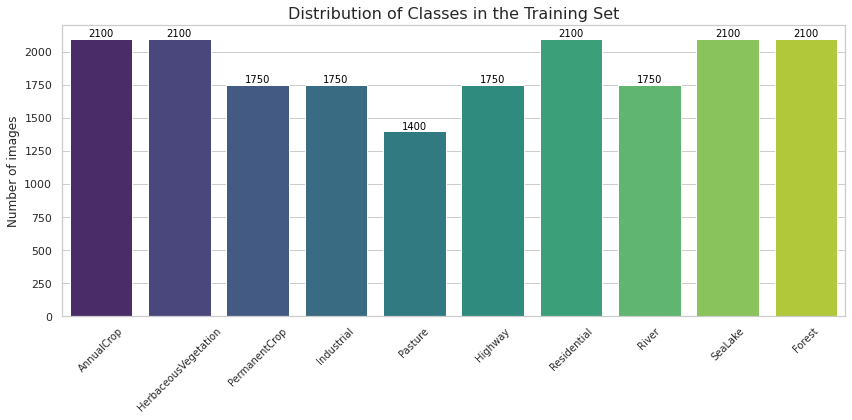

In [10]:
labels = train_dataset.data['Label'].values  # Assuming 'Label' is the column with labels

# Convert numerical labels to string names if necessary
label_names = [index_to_label[label] for label in labels]

sns.set(style="whitegrid")  # Set style
plt.figure(figsize=(12, 6))

# Adjusted according to the new API
ax = sns.countplot(x=label_names, hue=label_names, palette="viridis", legend=False)

#plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.title('Distribution of Classes in the Training Set', fontsize=16)
plt.xticks(rotation=45, fontsize=10)

# Add the count above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



# Model

In [11]:
# Use un-pretrained model
model = mobilenet_v3_small()

# Replace the model head with the number of classes
num_classes = 10
model.classifier[3] = nn.Linear(1024, num_classes) 
model.to(DEVICE)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

# Training model from Scratch

In [12]:
project_name = "EuroSAT"
model_name = "MobileNetV3"
models_path = "/datasets2/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models"

In [14]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="MobileNetV3 from scratch",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 lr=lr, patience=patience, device=DEVICE)

Starting training with early stopping patience of 10
Each epoch has 296 steps.

Epoch: 1...
Step: 21/296 Loss: 2.3011314392089846
Step: 41/296 Loss: 2.0991686642169953
Step: 61/296 Loss: 1.8913696467876435
Step: 81/296 Loss: 1.7183343291282653
Step: 101/296 Loss: 1.6319163978099822
Step: 121/296 Loss: 1.6180291831493379
Step: 141/296 Loss: 1.490299117565155
Step: 161/296 Loss: 1.4281364560127259
Step: 181/296 Loss: 1.381456047296524
Step: 201/296 Loss: 1.3029278457164764
Step: 221/296 Loss: 1.2699513018131257
Step: 241/296 Loss: 1.269538414478302
Step: 261/296 Loss: 1.1599487215280533
Step: 281/296 Loss: 1.1006219983100891
Validation Loss: 2.3869 Accuracy: 0.0926
Epoch duration: 38.26s

Epoch: 2...
Step: 21/296 Loss: 2.478395688533783
Step: 41/296 Loss: 2.3067577123641967
Step: 61/296 Loss: 2.3044795036315917
Step: 81/296 Loss: 2.29866623878479
Step: 101/296 Loss: 2.299169659614563
Step: 121/296 Loss: 2.299347937107086
Step: 141/296 Loss: 2.2923112511634827
Step: 161/296 Loss: 2.297367

Step: 81/296 Loss: 0.9141421347856522
Step: 101/296 Loss: 0.9132801175117493
Step: 121/296 Loss: 0.930494686961174
Step: 141/296 Loss: 0.8890944480895996
Step: 161/296 Loss: 0.8544192373752594
Step: 181/296 Loss: 0.8747286647558212
Step: 201/296 Loss: 0.8633345991373063
Step: 221/296 Loss: 0.9071292072534561
Step: 241/296 Loss: 0.8987577676773071
Step: 261/296 Loss: 0.8891807109117508
Step: 281/296 Loss: 0.8546003758907318
Validation Loss: 0.8632 Accuracy: 0.6765
Epoch duration: 37.01s

Epoch: 15...
Step: 21/296 Loss: 0.8843452632427216
Step: 41/296 Loss: 0.8036325693130493
Step: 61/296 Loss: 0.858968260884285
Step: 81/296 Loss: 0.8814653009176254
Step: 101/296 Loss: 0.8781349003314972
Step: 121/296 Loss: 0.8852101922035217
Step: 141/296 Loss: 0.8085202097892761
Step: 161/296 Loss: 0.8748968005180359
Step: 181/296 Loss: 0.8644925475120544
Step: 201/296 Loss: 0.8350386261940003
Step: 221/296 Loss: 0.8543892443180084
Step: 241/296 Loss: 0.8408718824386596
Step: 261/296 Loss: 0.8934839695

Step: 161/296 Loss: 0.6000430017709732
Step: 181/296 Loss: 0.6005144745111466
Step: 201/296 Loss: 0.6206310331821442
Step: 221/296 Loss: 0.6380002051591873
Step: 241/296 Loss: 0.6203339353203774
Step: 261/296 Loss: 0.5839067086577415
Step: 281/296 Loss: 0.6059384107589721
Validation Loss: 0.6485 Accuracy: 0.7626
Epoch duration: 37.06s

Epoch: 28...
Step: 21/296 Loss: 0.6223357409238816
Step: 41/296 Loss: 0.5929713636636734
Step: 61/296 Loss: 0.5864495635032654
Step: 81/296 Loss: 0.5669098645448685
Step: 101/296 Loss: 0.6141773715615273
Step: 121/296 Loss: 0.5896948933601379
Step: 141/296 Loss: 0.6299265533685684
Step: 161/296 Loss: 0.6218076914548873
Step: 181/296 Loss: 0.5947069436311722
Step: 201/296 Loss: 0.5850999310612679
Step: 221/296 Loss: 0.5934145167469979
Step: 241/296 Loss: 0.5938763722777367
Step: 261/296 Loss: 0.6023584619164467
Step: 281/296 Loss: 0.6356487080454827
Validation Loss: 0.6430 Accuracy: 0.7646
Epoch duration: 37.36s

Epoch: 29...
Step: 21/296 Loss: 0.61526089

Step: 241/296 Loss: 0.4957073122262955
Step: 261/296 Loss: 0.4923044204711914
Step: 281/296 Loss: 0.5590528607368469
Validation Loss: 0.5295 Accuracy: 0.8061
Epoch duration: 37.87s

Epoch: 41...
Step: 21/296 Loss: 0.5019766196608544
Step: 41/296 Loss: 0.49871290773153304
Step: 61/296 Loss: 0.4912909269332886
Step: 81/296 Loss: 0.4793639451265335
Step: 101/296 Loss: 0.49144145399332045
Step: 121/296 Loss: 0.48940649926662444
Step: 141/296 Loss: 0.5012385278940201
Step: 161/296 Loss: 0.4530965730547905
Step: 181/296 Loss: 0.4957703217864037
Step: 201/296 Loss: 0.47810725271701815
Step: 221/296 Loss: 0.4942102894186974
Step: 241/296 Loss: 0.4703190430998802
Step: 261/296 Loss: 0.5087285012006759
Step: 281/296 Loss: 0.5036642611026764
Validation Loss: 0.5295 Accuracy: 0.8048
Epoch duration: 37.61s

Epoch: 42...
Step: 21/296 Loss: 0.4868704155087471
Step: 41/296 Loss: 0.4686689183115959
Step: 61/296 Loss: 0.48952972143888474
Step: 81/296 Loss: 0.5118554025888443
Step: 101/296 Loss: 0.479795

Step: 281/296 Loss: 0.42948266714811323
Validation Loss: 0.5025 Accuracy: 0.8198
Epoch duration: 38.98s

Epoch: 54...
Step: 21/296 Loss: 0.4437626749277115
Step: 41/296 Loss: 0.3577983915805817
Step: 61/296 Loss: 0.4037760399281979
Step: 81/296 Loss: 0.4109675049781799
Step: 101/296 Loss: 0.40712851881980894
Step: 121/296 Loss: 0.4267346724867821
Step: 141/296 Loss: 0.4177372880280018
Step: 161/296 Loss: 0.42264433205127716
Step: 181/296 Loss: 0.47122755497694013
Step: 201/296 Loss: 0.4199386343359947
Step: 221/296 Loss: 0.4232103116810322
Step: 241/296 Loss: 0.42228509187698365
Step: 261/296 Loss: 0.41455988511443137
Step: 281/296 Loss: 0.45865423455834387
Validation Loss: 0.5019 Accuracy: 0.8215
Epoch duration: 38.99s

Epoch: 55...
Step: 21/296 Loss: 0.44713985696434977
Step: 41/296 Loss: 0.4402013376355171
Step: 61/296 Loss: 0.399075324088335
Step: 81/296 Loss: 0.4081778287887573
Step: 101/296 Loss: 0.4034020557999611
Step: 121/296 Loss: 0.37106058523058894
Step: 141/296 Loss: 0.417

Step: 21/296 Loss: 0.3996036723256111
Step: 41/296 Loss: 0.35166570693254473
Step: 61/296 Loss: 0.3316885694861412
Step: 81/296 Loss: 0.3804802753031254
Step: 101/296 Loss: 0.34517512544989587
Step: 121/296 Loss: 0.34171508327126504
Step: 141/296 Loss: 0.32984217032790186
Step: 161/296 Loss: 0.3691348575055599
Step: 181/296 Loss: 0.3559265211224556
Step: 201/296 Loss: 0.3694380961358547
Step: 221/296 Loss: 0.349260051548481
Step: 241/296 Loss: 0.35987456887960434
Step: 261/296 Loss: 0.32418888360261916
Step: 281/296 Loss: 0.37762525901198385
Validation Loss: 0.4856 Accuracy: 0.8280
Epoch duration: 40.39s

Epoch: 68...
Step: 21/296 Loss: 0.34876046180725095
Step: 41/296 Loss: 0.3670642875134945
Step: 61/296 Loss: 0.35959902554750445
Step: 81/296 Loss: 0.3427588641643524
Step: 101/296 Loss: 0.35531065091490743
Step: 121/296 Loss: 0.3667171709239483
Step: 141/296 Loss: 0.34599069133400917
Step: 161/296 Loss: 0.36730187088251115
Step: 181/296 Loss: 0.3680670283734798
Step: 201/296 Loss: 0.

Step: 61/296 Loss: 0.31125436574220655
Step: 81/296 Loss: 0.2997698776423931
Step: 101/296 Loss: 0.27641445621848104
Step: 121/296 Loss: 0.30237504541873933
Step: 141/296 Loss: 0.2738035060465336
Step: 161/296 Loss: 0.31989828646183016
Step: 181/296 Loss: 0.33846909552812576
Step: 201/296 Loss: 0.27965258061885834
Step: 221/296 Loss: 0.28863203823566436
Step: 241/296 Loss: 0.26991619542241096
Step: 261/296 Loss: 0.3132298789918423
Step: 281/296 Loss: 0.3020152010023594
Validation Loss: 0.4499 Accuracy: 0.8463
Epoch duration: 40.26s

Epoch: 81...
Step: 21/296 Loss: 0.32189640775322914
Step: 41/296 Loss: 0.2781894586980343
Step: 61/296 Loss: 0.3339409425854683
Step: 81/296 Loss: 0.2876160703599453
Step: 101/296 Loss: 0.2744444005191326
Step: 121/296 Loss: 0.294455499202013
Step: 141/296 Loss: 0.28187462240457534
Step: 161/296 Loss: 0.2637987516820431
Step: 181/296 Loss: 0.2750631559640169
Step: 201/296 Loss: 0.2992671377956867
Step: 221/296 Loss: 0.27167201563715937
Step: 241/296 Loss: 0

Step: 101/296 Loss: 0.24021329246461393
Step: 121/296 Loss: 0.26917554438114166
Step: 141/296 Loss: 0.2689798980951309
Step: 161/296 Loss: 0.27789763137698176
Step: 181/296 Loss: 0.2366092514246702
Step: 201/296 Loss: 0.21614547520875932
Step: 221/296 Loss: 0.2511920675635338
Step: 241/296 Loss: 0.2152816101908684
Step: 261/296 Loss: 0.2391672607511282
Step: 281/296 Loss: 0.2643151693046093
Validation Loss: 0.4778 Accuracy: 0.8528
Epoch duration: 38.21s

Epoch: 94...
Step: 21/296 Loss: 0.27641980051994325
Step: 41/296 Loss: 0.2507484838366508
Step: 61/296 Loss: 0.23265961185097694
Step: 81/296 Loss: 0.2429010860621929
Step: 101/296 Loss: 0.2559012293815613
Step: 121/296 Loss: 0.24840861707925796
Step: 141/296 Loss: 0.25134476348757745
Step: 161/296 Loss: 0.2170735001564026
Step: 181/296 Loss: 0.25907878056168554
Step: 201/296 Loss: 0.2047928348183632
Step: 221/296 Loss: 0.24671591594815254
Step: 241/296 Loss: 0.26116342321038244
Step: 261/296 Loss: 0.22754001319408418
Step: 281/296 Los

Step: 121/296 Loss: 0.18805807251483203
Step: 141/296 Loss: 0.18551165089011193
Step: 161/296 Loss: 0.20060434974730015
Step: 181/296 Loss: 0.20564105026423932
Step: 201/296 Loss: 0.22164902910590173
Step: 221/296 Loss: 0.19426433984190225
Step: 241/296 Loss: 0.22220452018082143
Step: 261/296 Loss: 0.2217899017035961
Step: 281/296 Loss: 0.20200491771101953
Validation Loss: 0.4518 Accuracy: 0.8646
Epoch duration: 38.48s

Epoch: 107...
Step: 21/296 Loss: 0.17328097783029078
Step: 41/296 Loss: 0.2001017726957798
Step: 61/296 Loss: 0.19147011265158653
Step: 81/296 Loss: 0.17621673736721277
Step: 101/296 Loss: 0.1880567654967308
Step: 121/296 Loss: 0.22046518847346305
Step: 141/296 Loss: 0.18234212920069695
Step: 161/296 Loss: 0.21645704992115497
Step: 181/296 Loss: 0.1882526498287916
Step: 201/296 Loss: 0.19860054813325406
Step: 221/296 Loss: 0.19926919937133789
Step: 241/296 Loss: 0.20707186870276928
Step: 261/296 Loss: 0.207987242937088
Step: 281/296 Loss: 0.21523351334035395
Validation 

Step: 121/296 Loss: 0.19169841557741166
Step: 141/296 Loss: 0.15956437811255456
Step: 161/296 Loss: 0.19301095083355904
Step: 181/296 Loss: 0.14536033496260642
Step: 201/296 Loss: 0.125486571341753
Step: 221/296 Loss: 0.1518661215901375
Step: 241/296 Loss: 0.13430426307022572
Step: 261/296 Loss: 0.16537947300821543
Step: 281/296 Loss: 0.1801603924483061
Validation Loss: 0.5286 Accuracy: 0.8600
Epoch duration: 38.44s

Epoch: 120...
Step: 21/296 Loss: 0.19524909388273953
Step: 41/296 Loss: 0.169011658616364
Step: 61/296 Loss: 0.14313382245600223
Step: 81/296 Loss: 0.15111735835671425
Step: 101/296 Loss: 0.1642842304892838
Step: 121/296 Loss: 0.16959697380661964
Step: 141/296 Loss: 0.14608138538897036
Step: 161/296 Loss: 0.15186726674437523
Step: 181/296 Loss: 0.16866936385631562
Step: 201/296 Loss: 0.177183673158288
Step: 221/296 Loss: 0.14952310584485531
Step: 241/296 Loss: 0.13713195808231832
Step: 261/296 Loss: 0.1435063114389777
Step: 281/296 Loss: 0.17598524261265994
Validation Loss

Step: 121/296 Loss: 0.08775000777095557
Step: 141/296 Loss: 0.13074859362095595
Step: 161/296 Loss: 0.14491343665868045
Step: 181/296 Loss: 0.14354195669293404
Step: 201/296 Loss: 0.12944916635751724
Step: 221/296 Loss: 0.1362461034208536
Step: 241/296 Loss: 0.12175481459125877
Step: 261/296 Loss: 0.10451446948572993
Step: 281/296 Loss: 0.13255178853869437
Validation Loss: 0.6111 Accuracy: 0.8637
Epoch duration: 38.42s

Epoch: 133...
Step: 21/296 Loss: 0.13202922102063894
Step: 41/296 Loss: 0.1144042395055294
Step: 61/296 Loss: 0.09768982818350196
Step: 81/296 Loss: 0.14303230941295625
Step: 101/296 Loss: 0.10573334619402885
Step: 121/296 Loss: 0.10098106954246759
Step: 141/296 Loss: 0.13411156926304102
Step: 161/296 Loss: 0.1420364983379841
Step: 181/296 Loss: 0.12836573272943497
Step: 201/296 Loss: 0.13149662204086782
Step: 221/296 Loss: 0.12866850104182959
Step: 241/296 Loss: 0.13622678574174643
Step: 261/296 Loss: 0.11303512779995799
Step: 281/296 Loss: 0.11863370873034
Validation 

## Save model

In [15]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: /datasets2/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/EuroSAT-MobileNetV3Small.pth


In [16]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as file:
    file.write(f"loss_i: {loss_i}\n")
    file.write(f"loss_val_i: {loss_val_i}\n")

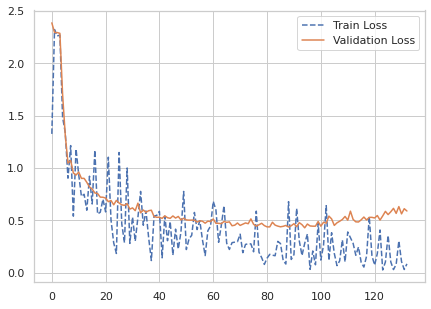

In [17]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [25]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load trained model

In [13]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + "/" + model_name + ".pth"
print(f"Loading {model_save_path}")
model.load_state_dict(torch.load(f = model_save_path))

Loading /datasets2/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/MobileNetV3.pth


<All keys matched successfully>

In [14]:
evaluate_test_set(model, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.895     0.907     0.901       300
              Forest      0.980     0.960     0.970       300
HerbaceousVegetation      0.870     0.780     0.822       300
             Highway      0.780     0.708     0.742       250
          Industrial      0.915     0.904     0.909       250
             Pasture      0.880     0.880     0.880       200
       PermanentCrop      0.727     0.832     0.776       250
         Residential      0.928     0.950     0.939       300
               River      0.768     0.848     0.806       250
             SeaLake      1.000     0.967     0.983       300

            accuracy                          0.877      2700
           macro avg      0.874     0.874     0.873      2700
        weighted avg      0.880     0.877     0.877      2700



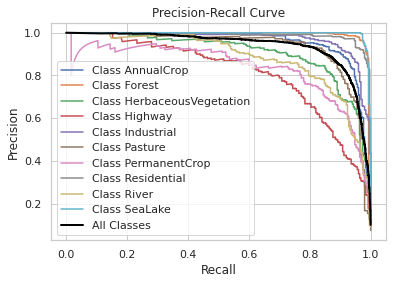

In [19]:
precision_recall_analysis(model, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [20]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,██▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▅▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
val_loss,██▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▂
epoch,132
step,39352
train_loss,0.11863
val_accuracy,0.86463
val_loss,0.58943


## Load the precision/recall curve and plot it

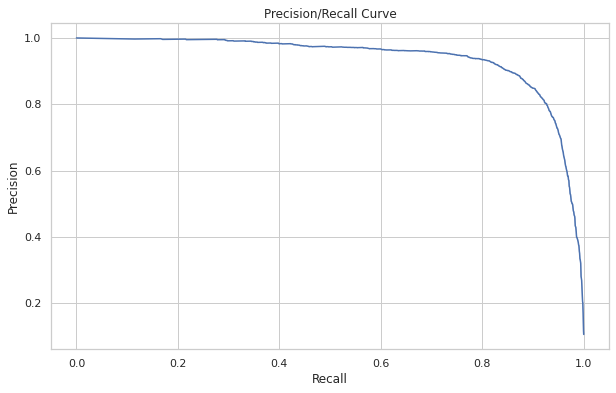

In [21]:
filename = f"{model_name}_precision_recall_values.json"
file_path = os.path.join(models_path, filename)

with open(file_path, 'r') as file:
    precision_recall_data = json.load(file)
    
all_classes_data = precision_recall_data['All Classes']

# Extract precision and recall values
precisions = all_classes_data.get('precision', [])
recalls = all_classes_data.get('recall', [])

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Precision': precisions,
    'Recall': recalls
})

# Plotting the precision/recall curve
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Recall', y='Precision')
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

## Clean-up

In [15]:
import gc

del model
torch.cuda.empty_cache()
gc.collect()


26120

# Now train the model with pre-trained weights

In [16]:
# Use pretrained model
model2=mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)

# Replace the model head with the number of classes
num_classes = 10
model2.classifier[3] = nn.Linear(1024, num_classes) 
model2.to(DEVICE)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

## Train

In [17]:
model_name = "MobileNetV3-Pretrained"

In [25]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="MobileNetV3 pre-trained on ImageNet",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model2, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 lr=lr, patience=patience, device=DEVICE)

Starting training with early stopping patience of 10
Each epoch has 296 steps.

Epoch: 1...
Step: 21/296 Loss: 2.4607228517532347
Step: 41/296 Loss: 1.8937954127788543
Step: 61/296 Loss: 1.5135390281677246
Step: 81/296 Loss: 1.290386712551117
Step: 101/296 Loss: 1.0714492082595826
Step: 121/296 Loss: 0.9588662415742875
Step: 141/296 Loss: 0.8319833159446717
Step: 161/296 Loss: 0.7614473938941956
Step: 181/296 Loss: 0.6931445330381394
Step: 201/296 Loss: 0.6480198472738266
Step: 221/296 Loss: 0.609596611559391
Step: 241/296 Loss: 0.561168409883976
Step: 261/296 Loss: 0.5577178940176963
Step: 281/296 Loss: 0.5182526990771293
Validation Loss: 0.4183 Accuracy: 0.8602
Epoch duration: 37.35s

Epoch: 2...
Step: 21/296 Loss: 0.3753866620361805
Step: 41/296 Loss: 0.35659772604703904
Step: 61/296 Loss: 0.30501428209245207
Step: 81/296 Loss: 0.3392614722251892
Step: 101/296 Loss: 0.3074328780174255
Step: 121/296 Loss: 0.3278833232820034
Step: 141/296 Loss: 0.25935164764523505
Step: 161/296 Loss: 

Step: 261/296 Loss: 0.013422197045292706
Step: 281/296 Loss: 0.012999372229387518
Validation Loss: 0.2792 Accuracy: 0.9413
Epoch duration: 37.21s

Epoch: 14...
Step: 21/296 Loss: 0.007809696531330701
Step: 41/296 Loss: 0.01282203099108301
Step: 61/296 Loss: 0.01908166206558235
Step: 81/296 Loss: 0.009115447016665713
Step: 101/296 Loss: 0.007721424096962437
Step: 121/296 Loss: 0.008247754574404098
Step: 141/296 Loss: 0.004907399298826931
Step: 161/296 Loss: 0.003201973604154773
Step: 181/296 Loss: 0.0016019353013689396
Step: 201/296 Loss: 0.006691391841741279
Step: 221/296 Loss: 0.005443756700697122
Step: 241/296 Loss: 0.009021959701749438
Step: 261/296 Loss: 0.019626077541033737
Step: 281/296 Loss: 0.03278478890933911
Validation Loss: 0.3168 Accuracy: 0.9376
Epoch duration: 37.57s

Epoch: 15...
Step: 21/296 Loss: 0.016892654402181507
Step: 41/296 Loss: 0.014535711263306439
Step: 61/296 Loss: 0.012217607951606623
Step: 81/296 Loss: 0.009996375875198282
Step: 101/296 Loss: 0.006255395385

Step: 141/296 Loss: 5.550389169002301e-05
Step: 161/296 Loss: 4.7604876579043774e-05
Step: 181/296 Loss: 5.553407750085171e-05
Step: 201/296 Loss: 5.5471546261287585e-05
Step: 221/296 Loss: 5.3538943950570685e-05
Step: 241/296 Loss: 5.7619149697529795e-05
Step: 261/296 Loss: 4.06868538902927e-05
Step: 281/296 Loss: 5.5807622038628325e-05
Validation Loss: 0.2730 Accuracy: 0.9546
Epoch duration: 37.54s

Epoch: 27...
Step: 21/296 Loss: 3.8799339722572765e-05
Step: 41/296 Loss: 4.436249905666045e-05
Step: 61/296 Loss: 6.681684253635467e-05
Step: 81/296 Loss: 4.87976886688557e-05
Step: 101/296 Loss: 3.615627056205994e-05
Step: 121/296 Loss: 3.699436822444113e-05
Step: 141/296 Loss: 3.800795943789126e-05
Step: 161/296 Loss: 4.111551534151659e-05
Step: 181/296 Loss: 4.191030143374519e-05
Step: 201/296 Loss: 3.4342496178396686e-05
Step: 221/296 Loss: 3.4152470561821247e-05
Step: 241/296 Loss: 3.821511472779093e-05
Step: 261/296 Loss: 4.2809484762074133e-05
Step: 281/296 Loss: 3.268681414283492

## Save model

In [26]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model2.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: /datasets2/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/EuroSAT-MobileNetV3-Pretrained.pth


In [27]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as archivo:
    archivo.write(f"loss_i: {loss_i}\n")
    archivo.write(f"loss_val_i: {loss_val_i}\n")

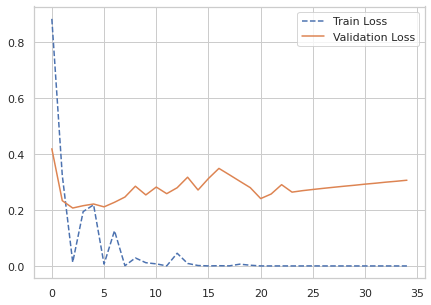

In [28]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [25]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load trained model

In [18]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + "/" + model_name + ".pth"
print(f"Loading {model_save_path}")
model2.load_state_dict(torch.load(f = model_save_path))

Loading /datasets2/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/MobileNetV3-Pretrained.pth


<All keys matched successfully>

In [19]:
evaluate_test_set(model2, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.963     0.967     0.965       300
              Forest      0.974     0.990     0.982       300
HerbaceousVegetation      0.928     0.947     0.937       300
             Highway      0.910     0.928     0.919       250
          Industrial      0.984     0.964     0.974       250
             Pasture      0.937     0.965     0.951       200
       PermanentCrop      0.936     0.880     0.907       250
         Residential      0.987     1.000     0.993       300
               River      0.943     0.924     0.933       250
             SeaLake      1.000     0.993     0.997       300

            accuracy                          0.958      2700
           macro avg      0.956     0.956     0.956      2700
        weighted avg      0.958     0.958     0.958      2700



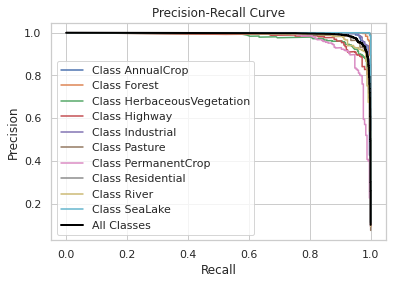

In [30]:
precision_recall_analysis(model2, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [31]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
val_loss,█▂▁▁▁▁▂▂▄▃▃▃▃▅▃▄▆▅▄▃▂▃▄▃▃▃▃▃▄▄▄▄▄▄▄
epoch,34
step,10344
train_loss,1e-05
val_accuracy,0.95426
val_loss,0.306


In [20]:
del model2
torch.cuda.empty_cache()
gc.collect()

18